In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pymc.sampling_jax
import bambi as bmb
import scipy.stats as stats
from scipy.stats import gaussian_kde
from sklearn.preprocessing import scale
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

/Users/corrado/opt/anaconda3/envs/pymc9_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
penguins = pd.read_csv("../data/penguins.csv")
# Subset to the columns needed
missing_data = penguins.isnull()[
    ["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]
].any(axis=1)
# Drop rows with any missing data
penguins = penguins.loc[~missing_data]
penguins.shape

(333, 8)

In [4]:
coords = {"species": ["Adelie", "Gentoo", "Chinstrap"]}

with pm.Model(coords=coords) as hierarchical_model:
    # Constant data for species indices
    species_idx = pm.ConstantData(
        "species_idx",
        penguins["species"].replace({"Adelie": 0, "Gentoo": 1, "Chinstrap": 2}).values,
    )

    # Hyperpriors
    mu_mean = pm.Normal("mu_mean", 4200, 1000)
    mu_sd = pm.HalfNormal("mu_sd", 500)
    sigma_mean = pm.HalfNormal("sigma_mean", 500)
    sigma_sd = pm.HalfNormal("sigma_sd", 100)
    
    # Normal priors for mu and sigma for each species
    mu = pm.Normal("mu", mu_mean, mu_sd, dims="species")
    sigma = pm.HalfNormal("sigma", sigma=sigma_mean, dims="species")

    # Likelihood
    y = pm.Normal(
        "y",
        mu=mu[species_idx],
        sigma=sigma[species_idx],
        observed=penguins["body_mass_g"],
    )

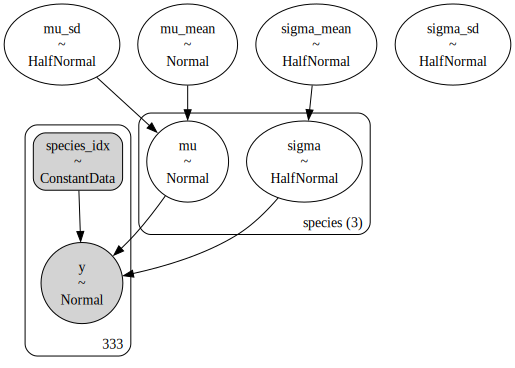

In [5]:
pm.model_to_graphviz(hierarchical_model)

In [6]:
with hierarchical_model:
    idata_pooling_prior_pred = pm.sample_prior_predictive(random_seed=rng)

Sampling: [mu, mu_mean, mu_sd, sigma, sigma_mean, sigma_sd, y]


In [7]:
likelihood_samples = idata_pooling_prior_pred.prior_predictive.y
flattened_array = np.ravel(likelihood_samples.values)

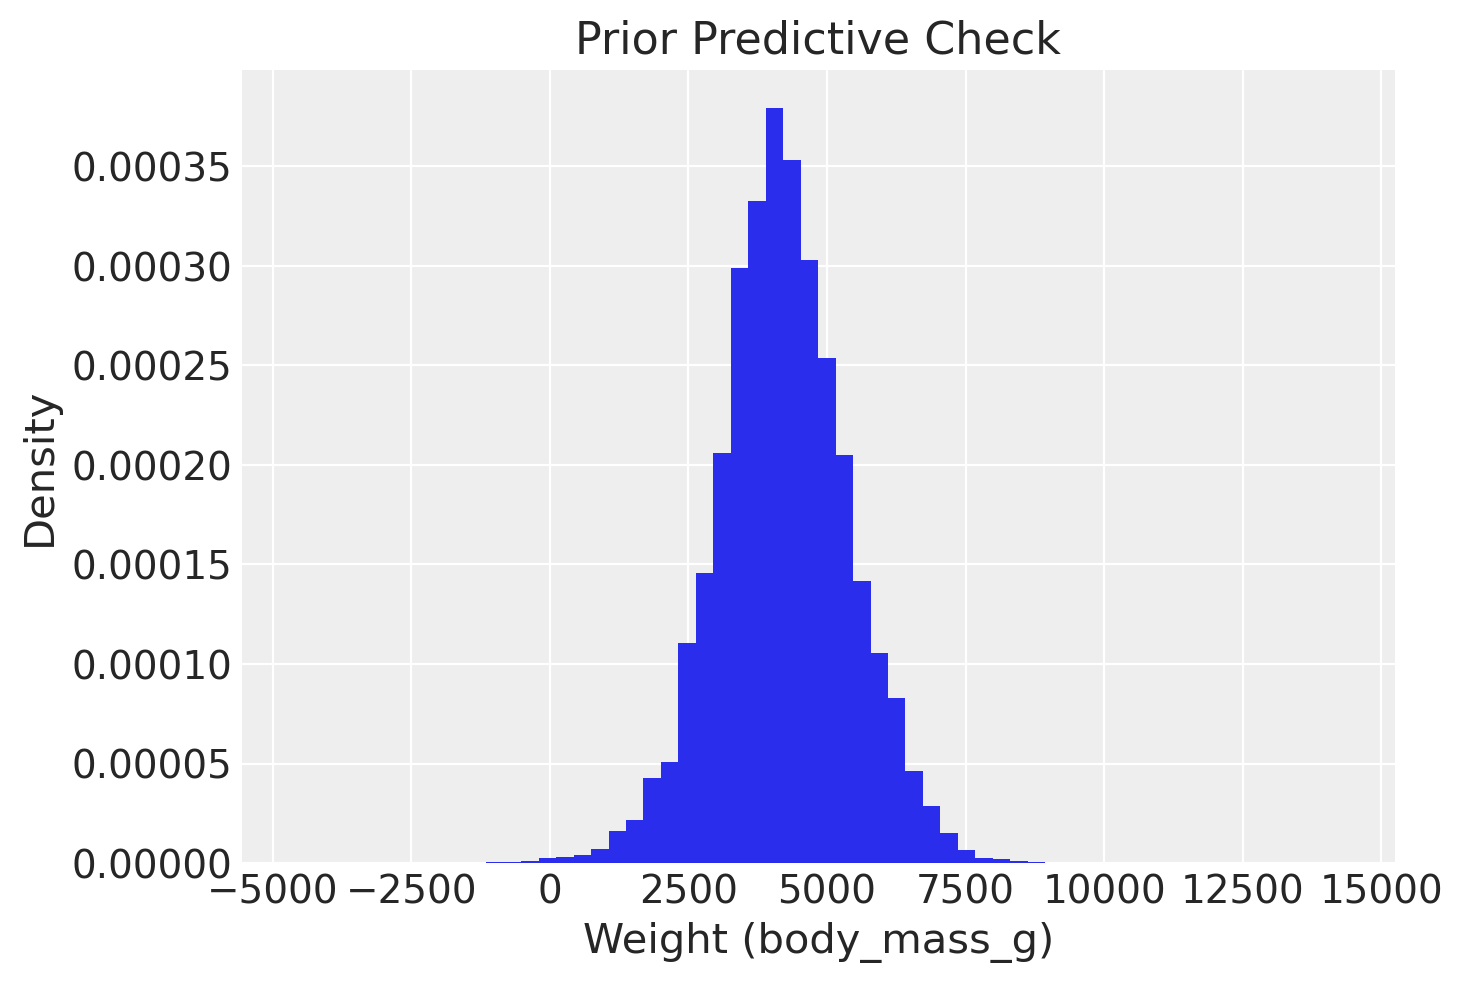

In [8]:
plt.hist(flattened_array, bins=60, density=True)
plt.xlabel('Weight (body_mass_g)')
plt.ylabel('Density')
plt.title('Prior Predictive Check')
plt.show()

In [9]:
with hierarchical_model:
    idata = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...


I0000 00:00:1699560276.643464       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
Compilation time = 0:00:01.107612


Sampling...


  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

  0%|                                                                                                | 0/2000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                  | 0/2000 [00:00<?, ?it/s]

Running chain 1:   0%|                                                                               | 0/2000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                               | 0/2000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                               | 0/2000 [00:01<?, ?it/s]

Running chain 3:   0%|                                                                               | 0/2000 [00:01<?, ?it/s]

Running chain 1:   5%|███▍                                                                | 100/2000 [00:02<00:05, 343.05it/s]

Running chain 0:   5%|███▍                                                                | 100/2000 [00:02<00:05, 320.10it/s]

Running chain 2:   5%|███▍                                                                | 100/2000 [00:02<00:06, 299.74it/s]

Running chain 3:   5%|███▍                                                                | 100/2000 [00:02<00:06, 297.02it/s]

Running chain 0:  90%|███████████████████████████████████████████████████████████▍      | 1800/2000 [00:02<00:00, 5539.17it/s]

Running chain 2: 100%|██████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 5843.71it/s]

Running chain 3:  85%|████████████████████████████████████████████████████████          | 1700/2000 [00:02<00:00, 4912.37it/s]

Running chain 0: 100%|███████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 844.23it/s]


Running chain 1: 100%|███████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 844.72it/s]


Running chain 2: 100%|███████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 845.21it/s]


Running chain 3: 100%|███████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 845.63it/s]

Sampling time = 0:00:02.608735


Transforming variables...


Transformation time = 0:00:00.096423


Computing Log Likelihood...


Log Likelihood time = 0:00:00.140860


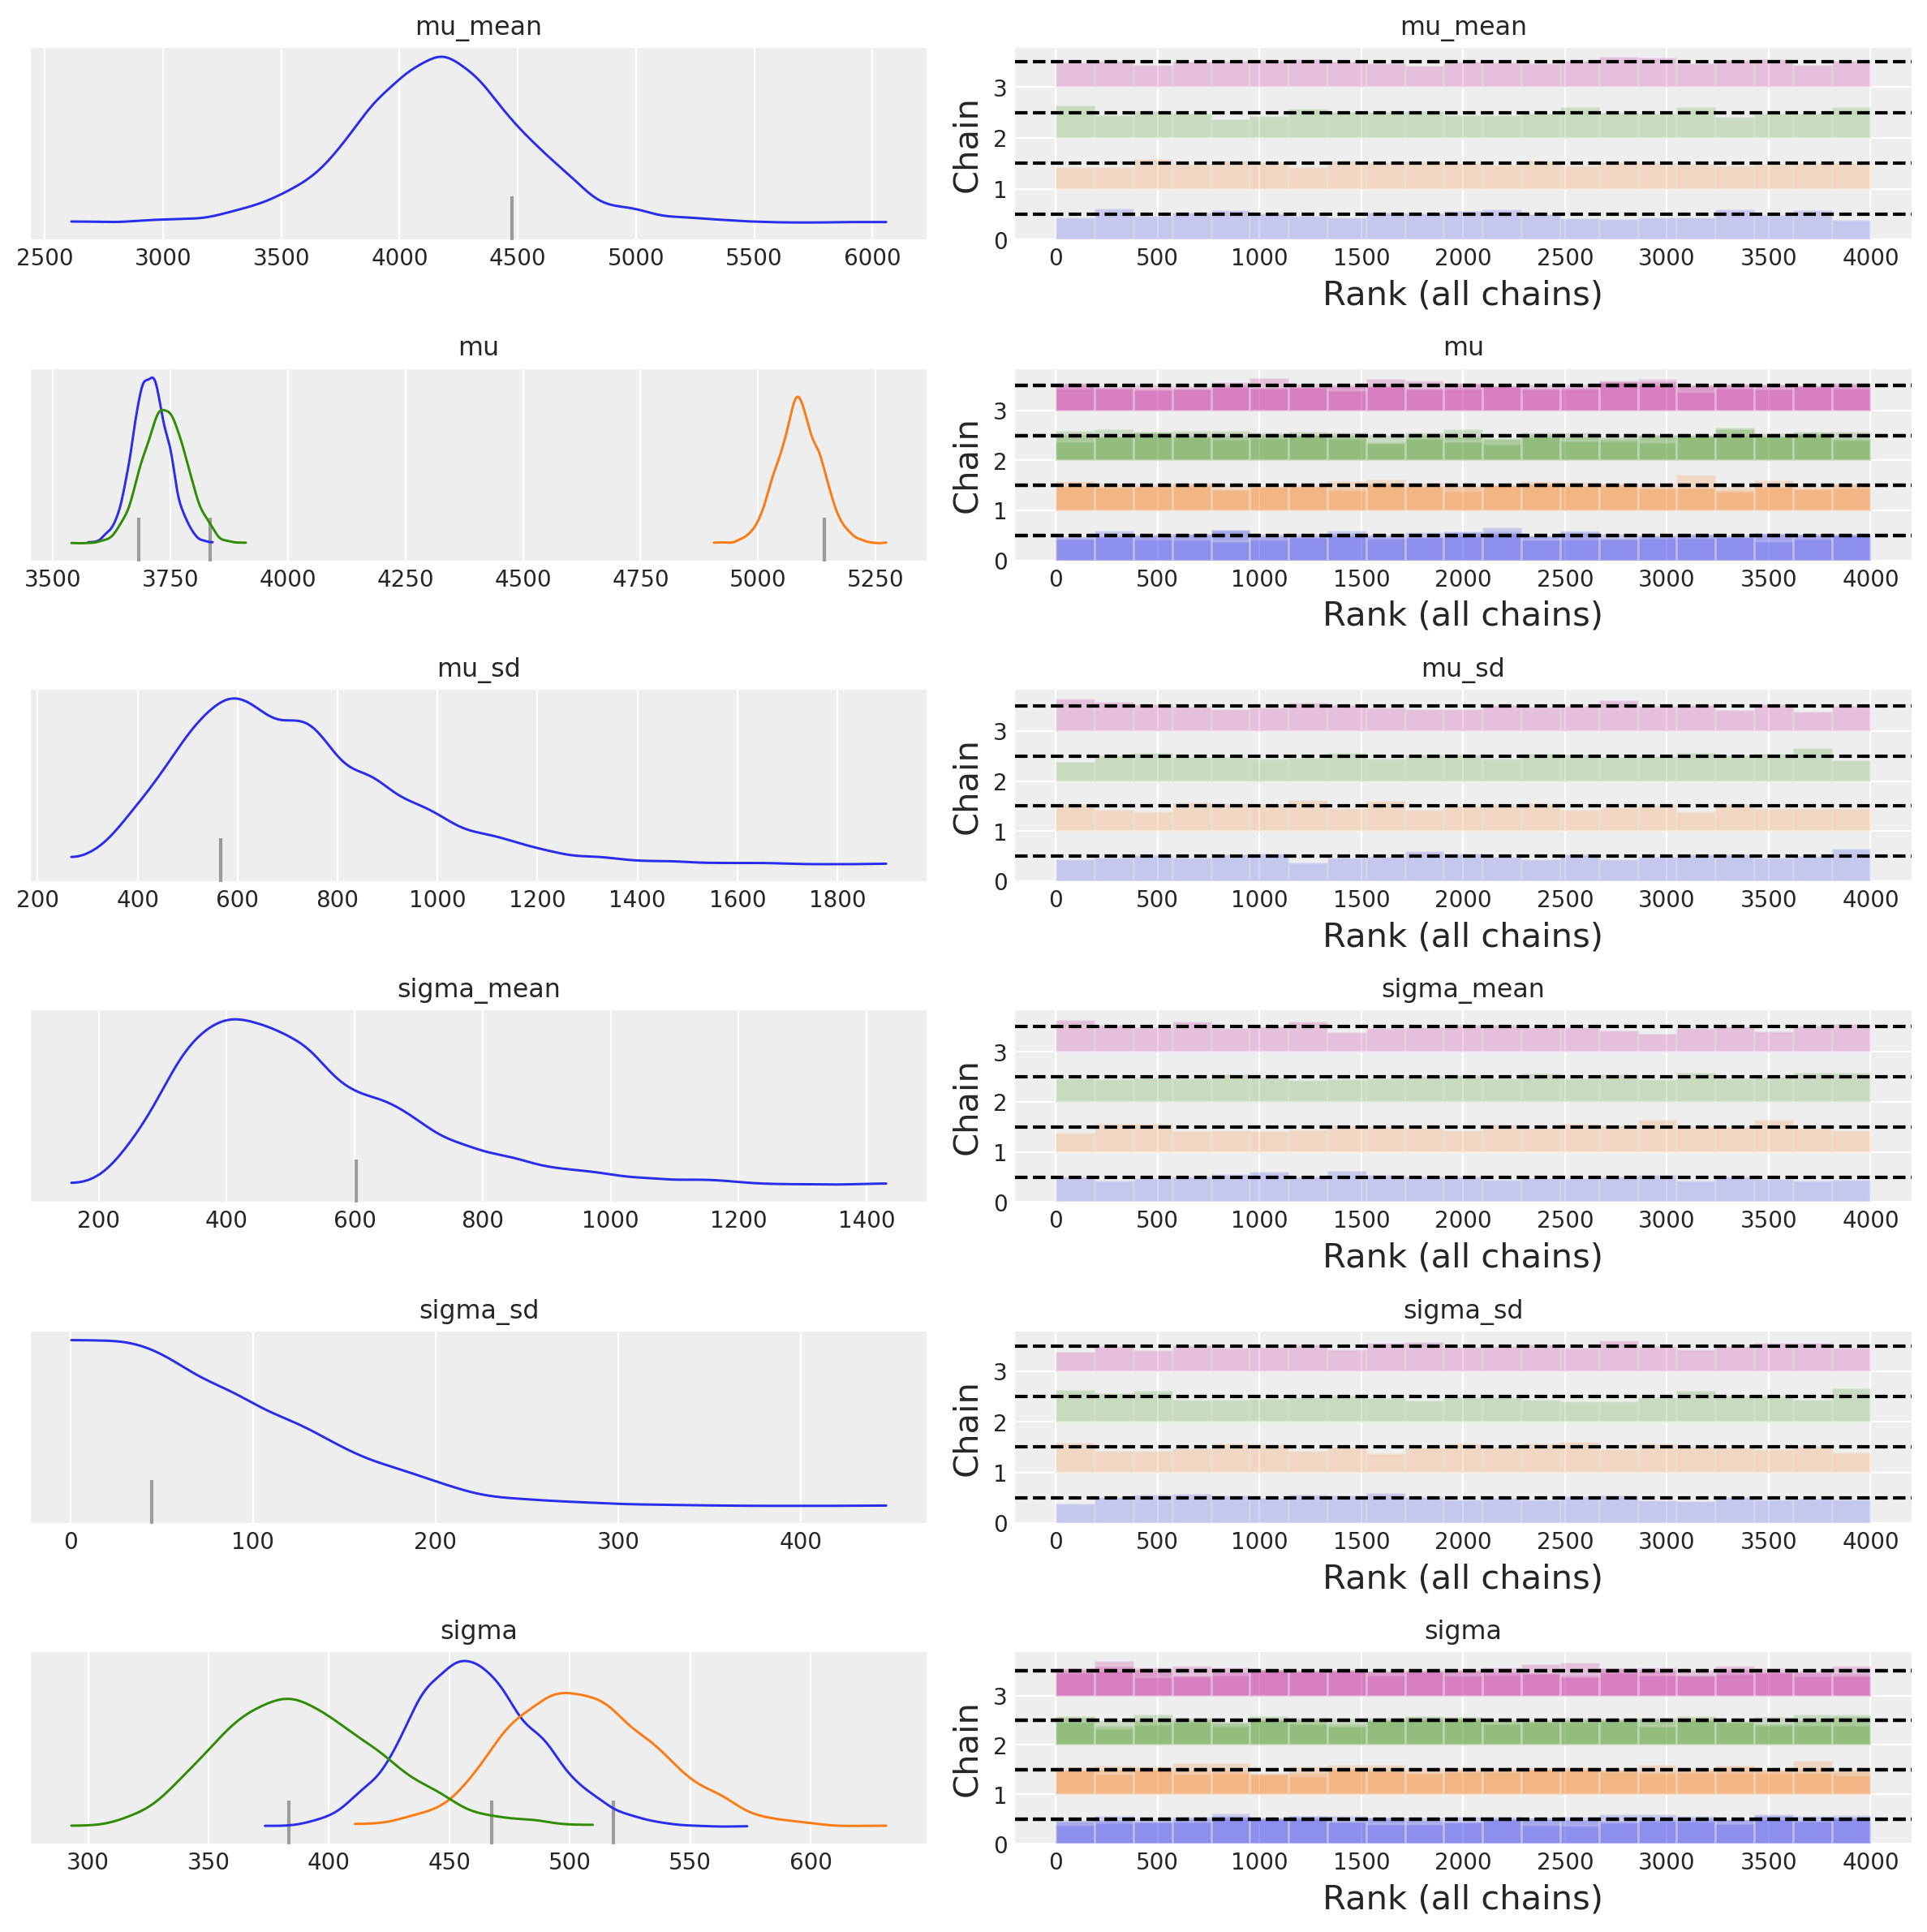

In [10]:
az.plot_trace(idata, combined=True, kind="rank_bars")
plt.tight_layout()
plt.show()

In [11]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_mean,4164.215,377.307,3401.162,4835.179,6.848,4.875,3148.0,2394.0,1.0
mu[Adelie],3707.225,37.918,3632.657,3776.245,0.552,0.391,4717.0,2745.0,1.0
mu[Gentoo],5088.068,46.954,4998.154,5173.480,0.694,0.491,4585.0,2857.0,1.0
mu[Chinstrap],3737.218,46.886,3649.121,3825.680,0.772,0.547,3705.0,2963.0,1.0
mu_sd,708.058,217.546,361.983,1131.928,3.720,2.729,3712.0,2981.0,1.0
sigma_mean,521.303,186.282,239.950,878.082,3.240,2.462,4086.0,2692.0,1.0
sigma_sd,79.666,59.780,0.043,184.647,0.900,0.636,2882.0,1553.0,1.0
sigma[Adelie],460.251,26.690,409.645,510.295,0.403,0.286,4423.0,2659.0,1.0
sigma[Gentoo],505.070,32.247,449.419,568.143,0.487,0.348,4477.0,2936.0,1.0
sigma[Chinstrap],389.097,34.207,327.894,452.967,0.528,0.382,4451.0,2634.0,1.0


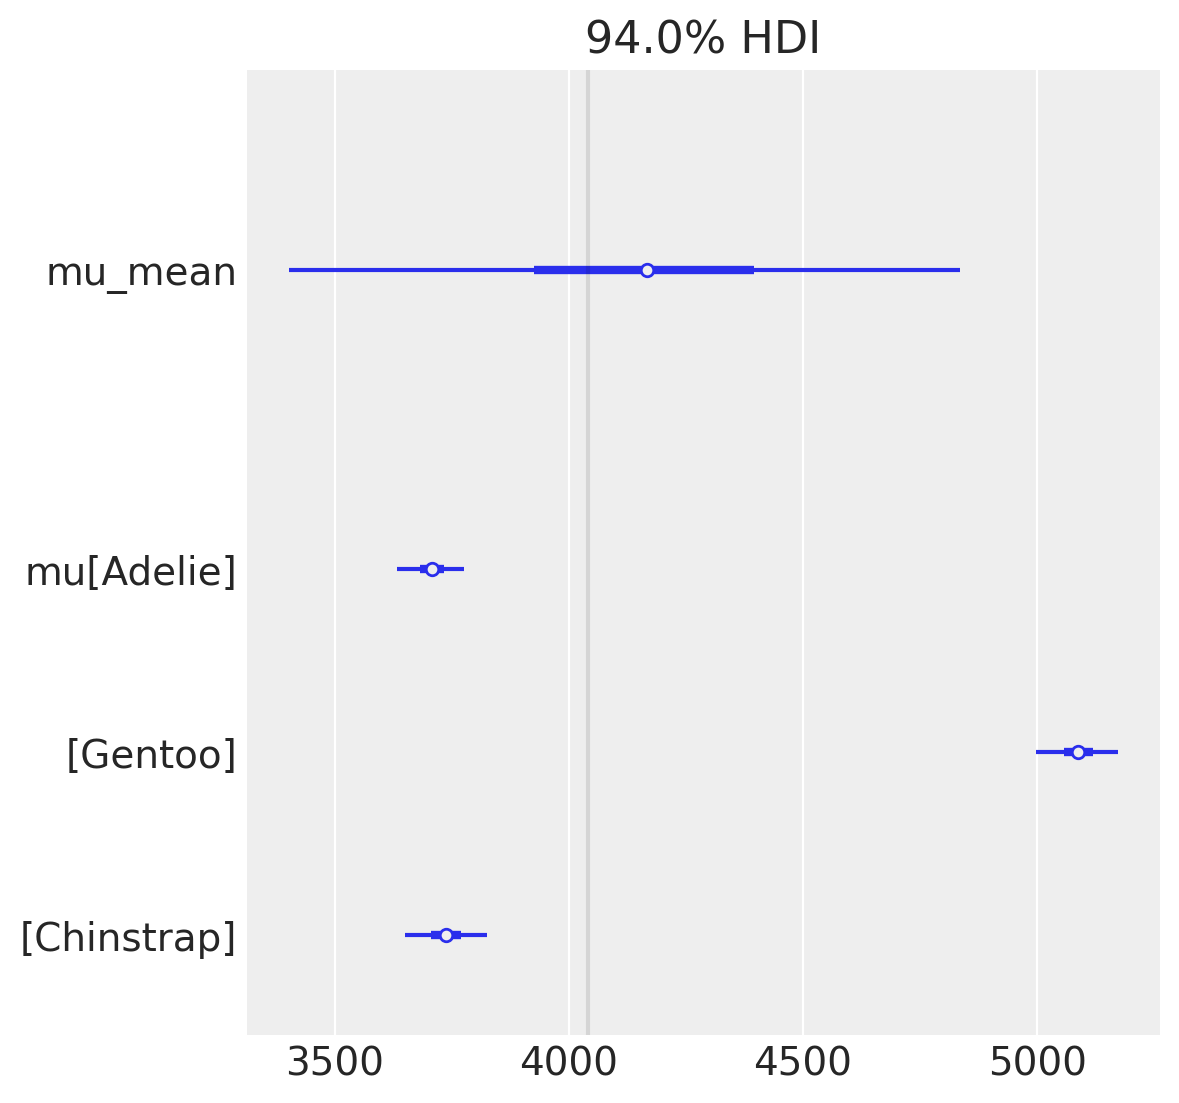

In [12]:
var_names=["mu_mean", "mu"]
az.plot_forest(idata, var_names=var_names, combined=True)
obs_mean=hierarchical_model["y"].eval().mean()
plt.axvline(x = obs_mean, color = 'black', alpha=0.1)
plt.show()

In [13]:
with hierarchical_model:
    post_pred = pm.sample_posterior_predictive(idata)

Sampling: [y]


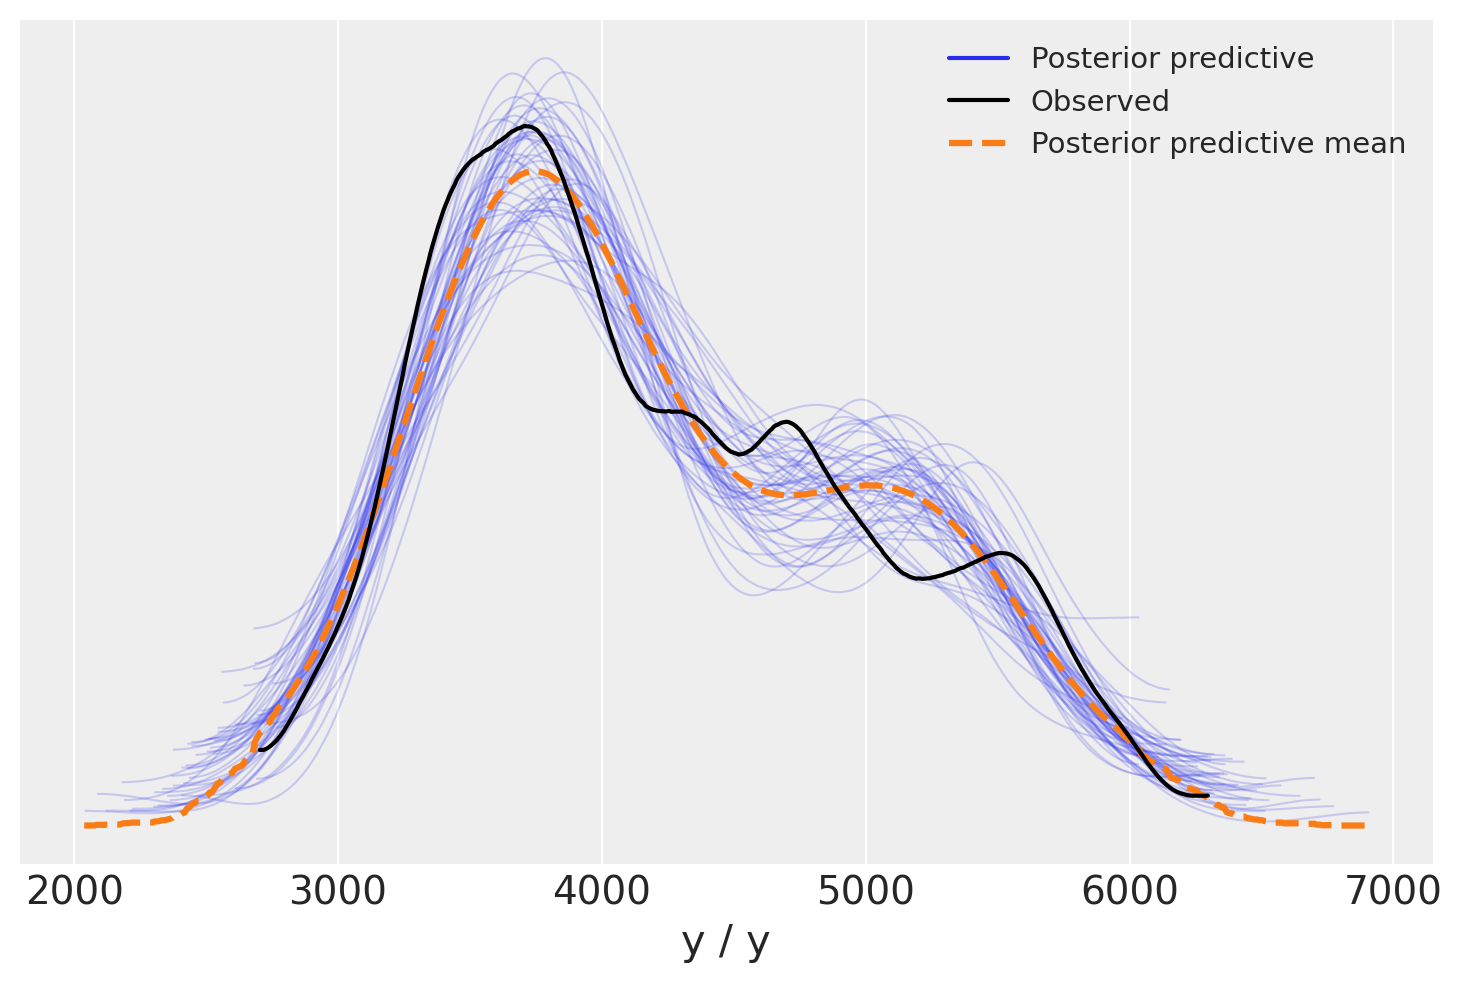

In [14]:
az.plot_ppc(post_pred, num_pp_samples=50)
plt.show()

In [15]:
m_loo = az.loo(idata)
m_loo

Computed from 4000 posterior samples and 333 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2516.14    11.71
p_loo        5.49        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      333  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Thu Nov 09 2023

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.16.1

pytensor: 2.13.1

scipy     : 1.11.3
pandas    : 2.1.1
numpy     : 1.25.2
arviz     : 0.16.1
seaborn   : 0.13.0
bambi     : 0.12.0
pymc      : 5.9.1
matplotlib: 3.8.0

Watermark: 2.4.3

